In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 32)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 32)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7429 - acc: 0.0823
Epoch 00001: val_loss improved from inf to 2.70514, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/001-2.7051.hdf5
36805/36805 [==============================] - 18s 490us/sample - loss: 2.7427 - acc: 0.0824 - val_loss: 2.7051 - val_acc: 0.0825
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.6880 - acc: 0.1102
Epoch 00002: val_loss improved from 2.70514 to 2.63207, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/002-2.6321.hdf5
36805/36805 [==============================] - 17s 452us/sample - loss: 2.6880 - acc: 0.1101 - val_loss: 2.6321 - val_acc: 0.1463
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6140 - acc: 0.1560
Epoch 00003: val_loss improved from 2.63207

Epoch 22/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9322 - acc: 0.3605
Epoch 00022: val_loss improved from 1.78415 to 1.76591, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/022-1.7659.hdf5
36805/36805 [==============================] - 16s 441us/sample - loss: 1.9322 - acc: 0.3605 - val_loss: 1.7659 - val_acc: 0.4670
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9214 - acc: 0.3611
Epoch 00023: val_loss improved from 1.76591 to 1.75116, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/023-1.7512.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 1.9214 - acc: 0.3611 - val_loss: 1.7512 - val_acc: 0.4666
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9079 - acc: 0.3675
Epoch 00024: val_loss improved from 1.75116 to 1.74002, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_ch

Epoch 44/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.7181 - acc: 0.4416
Epoch 00044: val_loss improved from 1.52512 to 1.51752, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/044-1.5175.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 1.7177 - acc: 0.4418 - val_loss: 1.5175 - val_acc: 0.5537
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7111 - acc: 0.4472
Epoch 00045: val_loss improved from 1.51752 to 1.50527, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/045-1.5053.hdf5
36805/36805 [==============================] - 16s 446us/sample - loss: 1.7112 - acc: 0.4472 - val_loss: 1.5053 - val_acc: 0.5584
Epoch 46/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.7030 - acc: 0.4455
Epoch 00046: val_loss improved from 1.50527 to 1.49792, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_ch

Epoch 66/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5822 - acc: 0.4928
Epoch 00066: val_loss improved from 1.36031 to 1.35372, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/066-1.3537.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 1.5825 - acc: 0.4928 - val_loss: 1.3537 - val_acc: 0.6024
Epoch 67/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5740 - acc: 0.4944
Epoch 00067: val_loss improved from 1.35372 to 1.34826, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/067-1.3483.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 1.5739 - acc: 0.4944 - val_loss: 1.3483 - val_acc: 0.6031
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5747 - acc: 0.4952
Epoch 00068: val_loss improved from 1.34826 to 1.33894, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_ch

Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4891 - acc: 0.5223
Epoch 00088: val_loss improved from 1.24121 to 1.23911, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/088-1.2391.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 1.4891 - acc: 0.5222 - val_loss: 1.2391 - val_acc: 0.6473
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4904 - acc: 0.5217
Epoch 00089: val_loss improved from 1.23911 to 1.23419, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/089-1.2342.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 1.4904 - acc: 0.5218 - val_loss: 1.2342 - val_acc: 0.6508
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4792 - acc: 0.5283
Epoch 00090: val_loss improved from 1.23419 to 1.22836, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_ch

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4199 - acc: 0.5491
Epoch 00111: val_loss improved from 1.16248 to 1.15572, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/111-1.1557.hdf5
36805/36805 [==============================] - 16s 447us/sample - loss: 1.4199 - acc: 0.5491 - val_loss: 1.1557 - val_acc: 0.6688
Epoch 112/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4194 - acc: 0.5468
Epoch 00112: val_loss did not improve from 1.15572
36805/36805 [==============================] - 16s 445us/sample - loss: 1.4199 - acc: 0.5468 - val_loss: 1.1575 - val_acc: 0.6676
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4204 - acc: 0.5487
Epoch 00113: val_loss improved from 1.15572 to 1.14814, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/113-1.1481.hdf5
36805/36805 [==============================] - 16s 447us/sample - loss: 1.4205 

Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3727 - acc: 0.5657
Epoch 00135: val_loss improved from 1.09216 to 1.08983, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/135-1.0898.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 1.3729 - acc: 0.5657 - val_loss: 1.0898 - val_acc: 0.6895
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3721 - acc: 0.5665
Epoch 00136: val_loss did not improve from 1.08983
36805/36805 [==============================] - 16s 444us/sample - loss: 1.3720 - acc: 0.5666 - val_loss: 1.0936 - val_acc: 0.6886
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3595 - acc: 0.5680
Epoch 00137: val_loss improved from 1.08983 to 1.08820, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/137-1.0882.hdf5
36805/36805 [==============================] - 16s 447us/sample - loss: 1.3595 

Epoch 159/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3331 - acc: 0.5789
Epoch 00159: val_loss improved from 1.05068 to 1.04384, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/159-1.0438.hdf5
36805/36805 [==============================] - 16s 444us/sample - loss: 1.3334 - acc: 0.5789 - val_loss: 1.0438 - val_acc: 0.6993
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3338 - acc: 0.5789
Epoch 00160: val_loss did not improve from 1.04384
36805/36805 [==============================] - 16s 443us/sample - loss: 1.3338 - acc: 0.5790 - val_loss: 1.0450 - val_acc: 0.7021
Epoch 161/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3213 - acc: 0.5816
Epoch 00161: val_loss did not improve from 1.04384
36805/36805 [==============================] - 16s 440us/sample - loss: 1.3215 - acc: 0.5815 - val_loss: 1.0442 - val_acc: 0.7016
Epoch 162/500
36800/36805 [============================>

Epoch 184/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3000 - acc: 0.5891
Epoch 00184: val_loss did not improve from 1.00528
36805/36805 [==============================] - 16s 437us/sample - loss: 1.2997 - acc: 0.5892 - val_loss: 1.0086 - val_acc: 0.7135
Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2860 - acc: 0.5933
Epoch 00185: val_loss improved from 1.00528 to 1.00099, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/185-1.0010.hdf5
36805/36805 [==============================] - 16s 445us/sample - loss: 1.2859 - acc: 0.5933 - val_loss: 1.0010 - val_acc: 0.7174
Epoch 186/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2912 - acc: 0.5921
Epoch 00186: val_loss did not improve from 1.00099
36805/36805 [==============================] - 16s 440us/sample - loss: 1.2910 - acc: 0.5923 - val_loss: 1.0103 - val_acc: 0.7100
Epoch 187/500
36800/36805 [============================>

Epoch 209/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2719 - acc: 0.5993
Epoch 00209: val_loss did not improve from 0.97342
36805/36805 [==============================] - 16s 446us/sample - loss: 1.2721 - acc: 0.5993 - val_loss: 0.9762 - val_acc: 0.7247
Epoch 210/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2666 - acc: 0.5991
Epoch 00210: val_loss improved from 0.97342 to 0.97249, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/210-0.9725.hdf5
36805/36805 [==============================] - 16s 441us/sample - loss: 1.2661 - acc: 0.5992 - val_loss: 0.9725 - val_acc: 0.7237
Epoch 211/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2634 - acc: 0.6006
Epoch 00211: val_loss did not improve from 0.97249
36805/36805 [==============================] - 16s 442us/sample - loss: 1.2633 - acc: 0.6006 - val_loss: 0.9737 - val_acc: 0.7263
Epoch 212/500
36800/36805 [============================>

Epoch 234/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2473 - acc: 0.6095
Epoch 00234: val_loss did not improve from 0.94712
36805/36805 [==============================] - 16s 443us/sample - loss: 1.2472 - acc: 0.6095 - val_loss: 0.9487 - val_acc: 0.7333
Epoch 235/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2481 - acc: 0.6083
Epoch 00235: val_loss improved from 0.94712 to 0.94604, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/235-0.9460.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 1.2480 - acc: 0.6083 - val_loss: 0.9460 - val_acc: 0.7363
Epoch 236/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2397 - acc: 0.6074
Epoch 00236: val_loss did not improve from 0.94604
36805/36805 [==============================] - 16s 445us/sample - loss: 1.2398 - acc: 0.6074 - val_loss: 0.9500 - val_acc: 0.7335
Epoch 237/500
36800/36805 [============================>

Epoch 260/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2203 - acc: 0.6159
Epoch 00260: val_loss did not improve from 0.92501
36805/36805 [==============================] - 16s 442us/sample - loss: 1.2205 - acc: 0.6158 - val_loss: 0.9257 - val_acc: 0.7393
Epoch 261/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2192 - acc: 0.6184
Epoch 00261: val_loss did not improve from 0.92501
36805/36805 [==============================] - 16s 447us/sample - loss: 1.2192 - acc: 0.6184 - val_loss: 0.9310 - val_acc: 0.7363
Epoch 262/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2193 - acc: 0.6172
Epoch 00262: val_loss did not improve from 0.92501
36805/36805 [==============================] - 16s 440us/sample - loss: 1.2196 - acc: 0.6172 - val_loss: 0.9290 - val_acc: 0.7398
Epoch 263/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2203 - acc: 0.6166
Epoch 00263: val_loss did not improve from 0.92501
36805/36805 [=

Epoch 286/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2056 - acc: 0.6237
Epoch 00286: val_loss did not improve from 0.90712
36805/36805 [==============================] - 16s 444us/sample - loss: 1.2056 - acc: 0.6238 - val_loss: 0.9096 - val_acc: 0.7470
Epoch 287/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2072 - acc: 0.6226
Epoch 00287: val_loss did not improve from 0.90712
36805/36805 [==============================] - 16s 445us/sample - loss: 1.2073 - acc: 0.6227 - val_loss: 0.9109 - val_acc: 0.7447
Epoch 288/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2019 - acc: 0.6255
Epoch 00288: val_loss did not improve from 0.90712
36805/36805 [==============================] - 16s 442us/sample - loss: 1.2020 - acc: 0.6255 - val_loss: 0.9111 - val_acc: 0.7480
Epoch 289/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2040 - acc: 0.6246
Epoch 00289: val_loss improved from 0.90712 to 0.90041, saving mo

Epoch 314/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1895 - acc: 0.6280
Epoch 00314: val_loss did not improve from 0.88876
36805/36805 [==============================] - 16s 441us/sample - loss: 1.1896 - acc: 0.6280 - val_loss: 0.8904 - val_acc: 0.7510
Epoch 315/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1771 - acc: 0.6317
Epoch 00315: val_loss improved from 0.88876 to 0.88600, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/315-0.8860.hdf5
36805/36805 [==============================] - 16s 446us/sample - loss: 1.1771 - acc: 0.6317 - val_loss: 0.8860 - val_acc: 0.7515
Epoch 316/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1887 - acc: 0.6264
Epoch 00316: val_loss did not improve from 0.88600
36805/36805 [==============================] - 16s 444us/sample - loss: 1.1886 - acc: 0.6264 - val_loss: 0.8940 - val_acc: 0.7482
Epoch 317/500
36736/36805 [============================>

36736/36805 [============================>.] - ETA: 0s - loss: 1.1765 - acc: 0.6342
Epoch 00341: val_loss did not improve from 0.87478
36805/36805 [==============================] - 16s 442us/sample - loss: 1.1764 - acc: 0.6342 - val_loss: 0.8816 - val_acc: 0.7552
Epoch 342/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1687 - acc: 0.6347
Epoch 00342: val_loss did not improve from 0.87478
36805/36805 [==============================] - 16s 448us/sample - loss: 1.1687 - acc: 0.6347 - val_loss: 0.8801 - val_acc: 0.7545
Epoch 343/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1739 - acc: 0.6342
Epoch 00343: val_loss did not improve from 0.87478
36805/36805 [==============================] - 16s 445us/sample - loss: 1.1742 - acc: 0.6341 - val_loss: 0.8748 - val_acc: 0.7533
Epoch 344/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1693 - acc: 0.6347
Epoch 00344: val_loss did not improve from 0.87478
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 1.1650 - acc: 0.6378
Epoch 00368: val_loss improved from 0.86625 to 0.86481, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/368-0.8648.hdf5
36805/36805 [==============================] - 16s 445us/sample - loss: 1.1650 - acc: 0.6378 - val_loss: 0.8648 - val_acc: 0.7598
Epoch 369/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1549 - acc: 0.6390
Epoch 00369: val_loss improved from 0.86481 to 0.86292, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/369-0.8629.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 1.1548 - acc: 0.6391 - val_loss: 0.8629 - val_acc: 0.7582
Epoch 370/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1656 - acc: 0.6375
Epoch 00370: val_loss did not improve from 0.86292
36805/36805 [==============================] - 16s 441us/sample - loss: 1.1656 - acc: 0.6375 

36800/36805 [============================>.] - ETA: 0s - loss: 1.1563 - acc: 0.6395
Epoch 00395: val_loss did not improve from 0.85344
36805/36805 [==============================] - 16s 443us/sample - loss: 1.1563 - acc: 0.6395 - val_loss: 0.8583 - val_acc: 0.7619
Epoch 396/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1488 - acc: 0.6410
Epoch 00396: val_loss did not improve from 0.85344
36805/36805 [==============================] - 16s 445us/sample - loss: 1.1488 - acc: 0.6411 - val_loss: 0.8549 - val_acc: 0.7608
Epoch 397/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1586 - acc: 0.6405
Epoch 00397: val_loss did not improve from 0.85344
36805/36805 [==============================] - 16s 440us/sample - loss: 1.1591 - acc: 0.6405 - val_loss: 0.8585 - val_acc: 0.7608
Epoch 398/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1561 - acc: 0.6410
Epoch 00398: val_loss did not improve from 0.85344
36805/36805 [===============

Epoch 422/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1459 - acc: 0.6448
Epoch 00422: val_loss did not improve from 0.84257
36805/36805 [==============================] - 16s 443us/sample - loss: 1.1459 - acc: 0.6447 - val_loss: 0.8479 - val_acc: 0.7631
Epoch 423/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1397 - acc: 0.6441
Epoch 00423: val_loss did not improve from 0.84257
36805/36805 [==============================] - 16s 442us/sample - loss: 1.1400 - acc: 0.6440 - val_loss: 0.8460 - val_acc: 0.7647
Epoch 424/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1456 - acc: 0.6467
Epoch 00424: val_loss did not improve from 0.84257
36805/36805 [==============================] - 16s 441us/sample - loss: 1.1455 - acc: 0.6467 - val_loss: 0.8478 - val_acc: 0.7645
Epoch 425/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1459 - acc: 0.6411
Epoch 00425: val_loss did not improve from 0.84257
36805/36805 [=

Epoch 451/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1386 - acc: 0.6469
Epoch 00451: val_loss did not improve from 0.83899
36805/36805 [==============================] - 16s 445us/sample - loss: 1.1387 - acc: 0.6468 - val_loss: 0.8403 - val_acc: 0.7692
Epoch 452/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1308 - acc: 0.6496
Epoch 00452: val_loss did not improve from 0.83899
36805/36805 [==============================] - 16s 442us/sample - loss: 1.1308 - acc: 0.6496 - val_loss: 0.8449 - val_acc: 0.7647
Epoch 453/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1353 - acc: 0.6479
Epoch 00453: val_loss improved from 0.83899 to 0.83738, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv_checkpoint/453-0.8374.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 1.1354 - acc: 0.6479 - val_loss: 0.8374 - val_acc: 0.7666
Epoch 454/500
36800/36805 [============================>

Epoch 478/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1235 - acc: 0.6487
Epoch 00478: val_loss did not improve from 0.82728
36805/36805 [==============================] - 16s 445us/sample - loss: 1.1235 - acc: 0.6487 - val_loss: 0.8369 - val_acc: 0.7673
Epoch 479/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1271 - acc: 0.6502
Epoch 00479: val_loss did not improve from 0.82728
36805/36805 [==============================] - 16s 445us/sample - loss: 1.1271 - acc: 0.6502 - val_loss: 0.8289 - val_acc: 0.7694
Epoch 480/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1170 - acc: 0.6524
Epoch 00480: val_loss did not improve from 0.82728
36805/36805 [==============================] - 16s 442us/sample - loss: 1.1170 - acc: 0.6525 - val_loss: 0.8293 - val_acc: 0.7682
Epoch 481/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1266 - acc: 0.6490
Epoch 00481: val_loss did not improve from 0.82728
36805/36805 [=

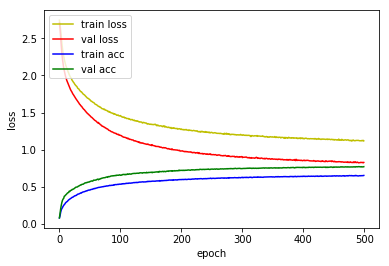

4815/4815 [==============================] - 1s 287us/sample - loss: 0.8719 - acc: 0.7433
Loss: 0.8719101119388053 Accuracy: 0.74330217

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7340 - acc: 0.0950
Epoch 00001: val_loss improved from inf to 2.66969, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/001-2.6697.hdf5
36805/36805 [==============================] - 18s 496us/sample - loss: 2.7340 - acc: 0.0950 - val_loss: 2.6697 - val_acc: 0.1332
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6070 - acc: 0.1586
Epoch 00002: val_loss improved from 2.66969 to 2.46063, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/002-2.4606.hdf5
36805/36805 [==============================] - 17s 462us/sample - loss: 2.6070 - acc: 0.1586 - val_loss: 2.4606 - val_acc: 0.2285
Epoch 3/500
36800/36805 [=========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6297 - acc: 0.4651
Epoch 00022: val_loss improved from 1.43329 to 1.41107, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/022-1.4111.hdf5
36805/36805 [==============================] - 17s 459us/sample - loss: 1.6299 - acc: 0.4650 - val_loss: 1.4111 - val_acc: 0.5833
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6157 - acc: 0.4718
Epoch 00023: val_loss improved from 1.41107 to 1.39379, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/023-1.3938.hdf5
36805/36805 [==============================] - 17s 461us/sample - loss: 1.6159 - acc: 0.4718 - val_loss: 1.3938 - val_acc: 0.5854
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5984 - acc: 0.4767
Epoch 00024: val_loss improved from 1.39379 to 1.37207, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_ch

Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3797 - acc: 0.5564
Epoch 00044: val_loss improved from 1.14625 to 1.14433, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/044-1.1443.hdf5
36805/36805 [==============================] - 17s 459us/sample - loss: 1.3797 - acc: 0.5564 - val_loss: 1.1443 - val_acc: 0.6555
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3706 - acc: 0.5610
Epoch 00045: val_loss improved from 1.14433 to 1.13184, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/045-1.1318.hdf5
36805/36805 [==============================] - 17s 458us/sample - loss: 1.3706 - acc: 0.5610 - val_loss: 1.1318 - val_acc: 0.6599
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3619 - acc: 0.5629
Epoch 00046: val_loss improved from 1.13184 to 1.12756, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_ch

Epoch 67/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2552 - acc: 0.6001
Epoch 00067: val_loss improved from 1.00869 to 0.99824, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/067-0.9982.hdf5
36805/36805 [==============================] - 17s 460us/sample - loss: 1.2552 - acc: 0.6001 - val_loss: 0.9982 - val_acc: 0.6988
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2472 - acc: 0.6052
Epoch 00068: val_loss did not improve from 0.99824
36805/36805 [==============================] - 17s 460us/sample - loss: 1.2472 - acc: 0.6052 - val_loss: 1.0057 - val_acc: 0.7067
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2475 - acc: 0.6036
Epoch 00069: val_loss improved from 0.99824 to 0.98733, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/069-0.9873.hdf5
36805/36805 [==============================] - 17s 457us/sample - loss: 1.2476 - a

Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1667 - acc: 0.6333
Epoch 00091: val_loss improved from 0.92209 to 0.91373, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/091-0.9137.hdf5
36805/36805 [==============================] - 17s 460us/sample - loss: 1.1667 - acc: 0.6333 - val_loss: 0.9137 - val_acc: 0.7293
Epoch 92/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1739 - acc: 0.6285
Epoch 00092: val_loss did not improve from 0.91373
36805/36805 [==============================] - 17s 458us/sample - loss: 1.1740 - acc: 0.6285 - val_loss: 0.9157 - val_acc: 0.7289
Epoch 93/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1657 - acc: 0.6339
Epoch 00093: val_loss did not improve from 0.91373
36805/36805 [==============================] - 17s 456us/sample - loss: 1.1657 - acc: 0.6339 - val_loss: 0.9229 - val_acc: 0.7284
Epoch 94/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 1.1199 - acc: 0.6508
Epoch 00115: val_loss improved from 0.86527 to 0.86516, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/115-0.8652.hdf5
36805/36805 [==============================] - 17s 460us/sample - loss: 1.1200 - acc: 0.6508 - val_loss: 0.8652 - val_acc: 0.7452
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1102 - acc: 0.6536
Epoch 00116: val_loss did not improve from 0.86516
36805/36805 [==============================] - 17s 465us/sample - loss: 1.1102 - acc: 0.6536 - val_loss: 0.8663 - val_acc: 0.7461
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1097 - acc: 0.6524
Epoch 00117: val_loss improved from 0.86516 to 0.85123, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/117-0.8512.hdf5
36805/36805 [==============================] - 17s 461us/sample - loss: 1.1096 - acc: 0.6524 

Epoch 141/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0750 - acc: 0.6653
Epoch 00141: val_loss did not improve from 0.81435
36805/36805 [==============================] - 16s 444us/sample - loss: 1.0748 - acc: 0.6654 - val_loss: 0.8146 - val_acc: 0.7584
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0697 - acc: 0.6660
Epoch 00142: val_loss did not improve from 0.81435
36805/36805 [==============================] - 16s 443us/sample - loss: 1.0697 - acc: 0.6660 - val_loss: 0.8171 - val_acc: 0.7624
Epoch 143/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0730 - acc: 0.6660
Epoch 00143: val_loss did not improve from 0.81435
36805/36805 [==============================] - 16s 445us/sample - loss: 1.0731 - acc: 0.6660 - val_loss: 0.8185 - val_acc: 0.7584
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0677 - acc: 0.6650
Epoch 00144: val_loss did not improve from 0.81435
36805/36805 [=

Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0394 - acc: 0.6788
Epoch 00167: val_loss did not improve from 0.78667
36805/36805 [==============================] - 17s 456us/sample - loss: 1.0393 - acc: 0.6788 - val_loss: 0.7873 - val_acc: 0.7692
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0347 - acc: 0.6782
Epoch 00168: val_loss improved from 0.78667 to 0.78356, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/168-0.7836.hdf5
36805/36805 [==============================] - 17s 460us/sample - loss: 1.0347 - acc: 0.6783 - val_loss: 0.7836 - val_acc: 0.7689
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0411 - acc: 0.6784
Epoch 00169: val_loss did not improve from 0.78356
36805/36805 [==============================] - 17s 458us/sample - loss: 1.0412 - acc: 0.6784 - val_loss: 0.7937 - val_acc: 0.7673
Epoch 170/500
36800/36805 [============================>

Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0123 - acc: 0.6879
Epoch 00193: val_loss did not improve from 0.76062
36805/36805 [==============================] - 17s 453us/sample - loss: 1.0123 - acc: 0.6879 - val_loss: 0.7628 - val_acc: 0.7768
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0183 - acc: 0.6865
Epoch 00194: val_loss did not improve from 0.76062
36805/36805 [==============================] - 17s 451us/sample - loss: 1.0183 - acc: 0.6866 - val_loss: 0.7608 - val_acc: 0.7780
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0104 - acc: 0.6852
Epoch 00195: val_loss improved from 0.76062 to 0.75684, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/195-0.7568.hdf5
36805/36805 [==============================] - 17s 454us/sample - loss: 1.0104 - acc: 0.6852 - val_loss: 0.7568 - val_acc: 0.7778
Epoch 196/500
36800/36805 [============================>

36736/36805 [============================>.] - ETA: 0s - loss: 0.9848 - acc: 0.6966
Epoch 00219: val_loss did not improve from 0.73947
36805/36805 [==============================] - 16s 445us/sample - loss: 0.9844 - acc: 0.6967 - val_loss: 0.7486 - val_acc: 0.7785
Epoch 220/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9882 - acc: 0.6960
Epoch 00220: val_loss did not improve from 0.73947
36805/36805 [==============================] - 17s 454us/sample - loss: 0.9882 - acc: 0.6960 - val_loss: 0.7526 - val_acc: 0.7773
Epoch 221/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9887 - acc: 0.6931
Epoch 00221: val_loss improved from 0.73947 to 0.73674, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/221-0.7367.hdf5
36805/36805 [==============================] - 17s 461us/sample - loss: 0.9886 - acc: 0.6932 - val_loss: 0.7367 - val_acc: 0.7831
Epoch 222/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 246/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9703 - acc: 0.7011
Epoch 00246: val_loss did not improve from 0.72019
36805/36805 [==============================] - 17s 459us/sample - loss: 0.9703 - acc: 0.7011 - val_loss: 0.7257 - val_acc: 0.7892
Epoch 247/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9768 - acc: 0.6988
Epoch 00247: val_loss did not improve from 0.72019
36805/36805 [==============================] - 17s 450us/sample - loss: 0.9769 - acc: 0.6987 - val_loss: 0.7305 - val_acc: 0.7892
Epoch 248/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9733 - acc: 0.6988
Epoch 00248: val_loss improved from 0.72019 to 0.71819, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/248-0.7182.hdf5
36805/36805 [==============================] - 17s 454us/sample - loss: 0.9734 - acc: 0.6987 - val_loss: 0.7182 - val_acc: 0.7890
Epoch 249/500
36800/36805 [============================>

Epoch 273/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9611 - acc: 0.7033
Epoch 00273: val_loss did not improve from 0.70515
36805/36805 [==============================] - 16s 443us/sample - loss: 0.9614 - acc: 0.7033 - val_loss: 0.7116 - val_acc: 0.7955
Epoch 274/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9625 - acc: 0.7030
Epoch 00274: val_loss did not improve from 0.70515
36805/36805 [==============================] - 17s 455us/sample - loss: 0.9625 - acc: 0.7029 - val_loss: 0.7163 - val_acc: 0.7939
Epoch 275/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9484 - acc: 0.7059
Epoch 00275: val_loss improved from 0.70515 to 0.70123, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/275-0.7012.hdf5
36805/36805 [==============================] - 17s 453us/sample - loss: 0.9484 - acc: 0.7059 - val_loss: 0.7012 - val_acc: 0.7952
Epoch 276/500
36800/36805 [============================>

Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9401 - acc: 0.7120
Epoch 00301: val_loss improved from 0.69207 to 0.69198, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/301-0.6920.hdf5
36805/36805 [==============================] - 17s 463us/sample - loss: 0.9402 - acc: 0.7120 - val_loss: 0.6920 - val_acc: 0.7990
Epoch 302/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9379 - acc: 0.7112
Epoch 00302: val_loss did not improve from 0.69198
36805/36805 [==============================] - 17s 459us/sample - loss: 0.9379 - acc: 0.7112 - val_loss: 0.6934 - val_acc: 0.8013
Epoch 303/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9365 - acc: 0.7115
Epoch 00303: val_loss did not improve from 0.69198
36805/36805 [==============================] - 17s 458us/sample - loss: 0.9365 - acc: 0.7115 - val_loss: 0.7043 - val_acc: 0.7957
Epoch 304/500
36800/36805 [============================>

Epoch 329/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9285 - acc: 0.7138
Epoch 00329: val_loss did not improve from 0.67762
36805/36805 [==============================] - 17s 454us/sample - loss: 0.9284 - acc: 0.7138 - val_loss: 0.6797 - val_acc: 0.8046
Epoch 330/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9277 - acc: 0.7153
Epoch 00330: val_loss improved from 0.67762 to 0.67577, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/330-0.6758.hdf5
36805/36805 [==============================] - 17s 461us/sample - loss: 0.9276 - acc: 0.7153 - val_loss: 0.6758 - val_acc: 0.8074
Epoch 331/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9241 - acc: 0.7190
Epoch 00331: val_loss did not improve from 0.67577
36805/36805 [==============================] - 17s 455us/sample - loss: 0.9240 - acc: 0.7191 - val_loss: 0.6823 - val_acc: 0.8020
Epoch 332/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.9116 - acc: 0.7186
Epoch 00357: val_loss did not improve from 0.66600
36805/36805 [==============================] - 17s 457us/sample - loss: 0.9117 - acc: 0.7185 - val_loss: 0.6674 - val_acc: 0.8097
Epoch 358/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9142 - acc: 0.7176
Epoch 00358: val_loss did not improve from 0.66600
36805/36805 [==============================] - 17s 456us/sample - loss: 0.9144 - acc: 0.7175 - val_loss: 0.6666 - val_acc: 0.8092
Epoch 359/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9132 - acc: 0.7173
Epoch 00359: val_loss did not improve from 0.66600
36805/36805 [==============================] - 17s 463us/sample - loss: 0.9131 - acc: 0.7173 - val_loss: 0.6695 - val_acc: 0.8071
Epoch 360/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9136 - acc: 0.7189
Epoch 00360: val_loss improved from 0.66600 to 0.66197, saving model to model/c

Epoch 385/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8949 - acc: 0.7227
Epoch 00385: val_loss improved from 0.65495 to 0.65342, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_4_conv_checkpoint/385-0.6534.hdf5
36805/36805 [==============================] - 17s 461us/sample - loss: 0.8949 - acc: 0.7228 - val_loss: 0.6534 - val_acc: 0.8164
Epoch 386/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9031 - acc: 0.7212
Epoch 00386: val_loss did not improve from 0.65342
36805/36805 [==============================] - 17s 456us/sample - loss: 0.9030 - acc: 0.7212 - val_loss: 0.6616 - val_acc: 0.8148
Epoch 387/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8990 - acc: 0.7235
Epoch 00387: val_loss did not improve from 0.65342
36805/36805 [==============================] - 17s 459us/sample - loss: 0.8989 - acc: 0.7235 - val_loss: 0.6647 - val_acc: 0.8137
Epoch 388/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.8851 - acc: 0.7274
Epoch 00412: val_loss did not improve from 0.64041
36805/36805 [==============================] - 16s 445us/sample - loss: 0.8852 - acc: 0.7273 - val_loss: 0.6483 - val_acc: 0.8171
Epoch 413/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8892 - acc: 0.7274
Epoch 00413: val_loss did not improve from 0.64041
36805/36805 [==============================] - 17s 452us/sample - loss: 0.8891 - acc: 0.7274 - val_loss: 0.6484 - val_acc: 0.8209
Epoch 414/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8905 - acc: 0.7257
Epoch 00414: val_loss did not improve from 0.64041
36805/36805 [==============================] - 17s 453us/sample - loss: 0.8904 - acc: 0.7258 - val_loss: 0.6505 - val_acc: 0.8197
Epoch 415/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8876 - acc: 0.7256
Epoch 00415: val_loss did not improve from 0.64041
36805/36805 [===============

Epoch 440/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8686 - acc: 0.7330
Epoch 00440: val_loss did not improve from 0.63430
36805/36805 [==============================] - 17s 459us/sample - loss: 0.8686 - acc: 0.7330 - val_loss: 0.6358 - val_acc: 0.8262
Epoch 441/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8705 - acc: 0.7340
Epoch 00441: val_loss did not improve from 0.63430
36805/36805 [==============================] - 17s 459us/sample - loss: 0.8705 - acc: 0.7340 - val_loss: 0.6395 - val_acc: 0.8223
Epoch 442/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8764 - acc: 0.7293
Epoch 00442: val_loss did not improve from 0.63430
36805/36805 [==============================] - 17s 457us/sample - loss: 0.8763 - acc: 0.7294 - val_loss: 0.6372 - val_acc: 0.8227
Epoch 443/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8746 - acc: 0.7324
Epoch 00443: val_loss improved from 0.63430 to 0.63061, saving mo

Epoch 468/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8719 - acc: 0.7320
Epoch 00468: val_loss did not improve from 0.62523
36805/36805 [==============================] - 17s 458us/sample - loss: 0.8719 - acc: 0.7320 - val_loss: 0.6363 - val_acc: 0.8248
Epoch 469/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8666 - acc: 0.7329
Epoch 00469: val_loss did not improve from 0.62523
36805/36805 [==============================] - 17s 458us/sample - loss: 0.8666 - acc: 0.7329 - val_loss: 0.6385 - val_acc: 0.8230
Epoch 470/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8677 - acc: 0.7370
Epoch 00470: val_loss did not improve from 0.62523
36805/36805 [==============================] - 17s 459us/sample - loss: 0.8677 - acc: 0.7370 - val_loss: 0.6391 - val_acc: 0.8190
Epoch 471/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8650 - acc: 0.7357
Epoch 00471: val_loss did not improve from 0.62523
36805/36805 [=

Epoch 496/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8608 - acc: 0.7336
Epoch 00496: val_loss did not improve from 0.61686
36805/36805 [==============================] - 17s 457us/sample - loss: 0.8608 - acc: 0.7336 - val_loss: 0.6329 - val_acc: 0.8213
Epoch 497/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8611 - acc: 0.7349
Epoch 00497: val_loss did not improve from 0.61686
36805/36805 [==============================] - 17s 456us/sample - loss: 0.8611 - acc: 0.7349 - val_loss: 0.6278 - val_acc: 0.8234
Epoch 498/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8615 - acc: 0.7358
Epoch 00498: val_loss did not improve from 0.61686
36805/36805 [==============================] - 17s 459us/sample - loss: 0.8615 - acc: 0.7358 - val_loss: 0.6189 - val_acc: 0.8269
Epoch 499/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8588 - acc: 0.7358
Epoch 00499: val_loss did not improve from 0.61686
36805/36805 [=

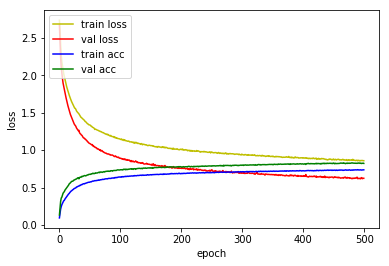

4815/4815 [==============================] - 1s 277us/sample - loss: 0.6655 - acc: 0.8000
Loss: 0.6654508444255263 Accuracy: 0.8

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6838 - acc: 0.1191
Epoch 00001: val_loss improved from inf to 2.50539, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/001-2.5054.hdf5
36805/36805 [==============================] - 19s 529us/sample - loss: 2.6838 - acc: 0.1191 - val_loss: 2.5054 - val_acc: 0.2392
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3724 - acc: 0.2274
Epoch 00002: val_loss improved from 2.50539 to 2.15333, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/002-2.1533.hdf5
36805/36805 [==============================] - 18s 480us/sample - loss: 2.3724 - acc: 0.2273 - val_loss: 2.1533 - val_acc: 0.3594
Epoch 3/500
36800/36805 [============================>.] 

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3416 - acc: 0.5764
Epoch 00022: val_loss improved from 1.15523 to 1.13259, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/022-1.1326.hdf5
36805/36805 [==============================] - 18s 476us/sample - loss: 1.3417 - acc: 0.5763 - val_loss: 1.1326 - val_acc: 0.6650
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3216 - acc: 0.5841
Epoch 00023: val_loss improved from 1.13259 to 1.13253, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/023-1.1325.hdf5
36805/36805 [==============================] - 18s 476us/sample - loss: 1.3216 - acc: 0.5841 - val_loss: 1.1325 - val_acc: 0.6746
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3093 - acc: 0.5904
Epoch 00024: val_loss did not improve from 1.13253
36805/36805 [==============================] - 17s 474us/sample - loss: 1.3093 - a

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0375 - acc: 0.6844
Epoch 00045: val_loss improved from 0.83680 to 0.82647, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/045-0.8265.hdf5
36805/36805 [==============================] - 18s 476us/sample - loss: 1.0375 - acc: 0.6844 - val_loss: 0.8265 - val_acc: 0.7673
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0289 - acc: 0.6879
Epoch 00046: val_loss improved from 0.82647 to 0.81804, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/046-0.8180.hdf5
36805/36805 [==============================] - 17s 474us/sample - loss: 1.0289 - acc: 0.6879 - val_loss: 0.8180 - val_acc: 0.7692
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0188 - acc: 0.6903
Epoch 00047: val_loss improved from 0.81804 to 0.81426, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_ch

Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8810 - acc: 0.7354
Epoch 00068: val_loss did not improve from 0.66904
36805/36805 [==============================] - 17s 473us/sample - loss: 0.8810 - acc: 0.7354 - val_loss: 0.6739 - val_acc: 0.8050
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8767 - acc: 0.7373
Epoch 00069: val_loss improved from 0.66904 to 0.65970, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/069-0.6597.hdf5
36805/36805 [==============================] - 17s 474us/sample - loss: 0.8766 - acc: 0.7373 - val_loss: 0.6597 - val_acc: 0.8099
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8615 - acc: 0.7418
Epoch 00070: val_loss did not improve from 0.65970
36805/36805 [==============================] - 18s 478us/sample - loss: 0.8615 - acc: 0.7418 - val_loss: 0.6754 - val_acc: 0.8085
Epoch 71/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.7797 - acc: 0.7704
Epoch 00091: val_loss improved from 0.56635 to 0.55967, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/091-0.5597.hdf5
36805/36805 [==============================] - 18s 478us/sample - loss: 0.7796 - acc: 0.7704 - val_loss: 0.5597 - val_acc: 0.8407
Epoch 92/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7758 - acc: 0.7707
Epoch 00092: val_loss did not improve from 0.55967
36805/36805 [==============================] - 18s 478us/sample - loss: 0.7758 - acc: 0.7708 - val_loss: 0.5675 - val_acc: 0.8390
Epoch 93/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7739 - acc: 0.7703
Epoch 00093: val_loss did not improve from 0.55967
36805/36805 [==============================] - 17s 473us/sample - loss: 0.7739 - acc: 0.7703 - val_loss: 0.5601 - val_acc: 0.8386
Epoch 94/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.7027 - acc: 0.7914
Epoch 00115: val_loss improved from 0.49846 to 0.48852, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/115-0.4885.hdf5
36805/36805 [==============================] - 17s 474us/sample - loss: 0.7026 - acc: 0.7914 - val_loss: 0.4885 - val_acc: 0.8675
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7082 - acc: 0.7918
Epoch 00116: val_loss did not improve from 0.48852
36805/36805 [==============================] - 17s 474us/sample - loss: 0.7083 - acc: 0.7918 - val_loss: 0.4913 - val_acc: 0.8665
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6983 - acc: 0.7929
Epoch 00117: val_loss did not improve from 0.48852
36805/36805 [==============================] - 18s 476us/sample - loss: 0.6983 - acc: 0.7929 - val_loss: 0.4896 - val_acc: 0.8658
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.6492 - acc: 0.8068
Epoch 00140: val_loss did not improve from 0.44634
36805/36805 [==============================] - 18s 477us/sample - loss: 0.6492 - acc: 0.8068 - val_loss: 0.4860 - val_acc: 0.8684
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6504 - acc: 0.8060
Epoch 00141: val_loss did not improve from 0.44634
36805/36805 [==============================] - 17s 473us/sample - loss: 0.6503 - acc: 0.8060 - val_loss: 0.4756 - val_acc: 0.8684
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6402 - acc: 0.8108
Epoch 00142: val_loss improved from 0.44634 to 0.44205, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/142-0.4420.hdf5
36805/36805 [==============================] - 18s 478us/sample - loss: 0.6401 - acc: 0.8108 - val_loss: 0.4420 - val_acc: 0.8777
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5976 - acc: 0.8232
Epoch 00166: val_loss did not improve from 0.40985
36805/36805 [==============================] - 17s 475us/sample - loss: 0.5977 - acc: 0.8231 - val_loss: 0.4446 - val_acc: 0.8800
Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5949 - acc: 0.8224
Epoch 00167: val_loss did not improve from 0.40985
36805/36805 [==============================] - 17s 474us/sample - loss: 0.5948 - acc: 0.8224 - val_loss: 0.4133 - val_acc: 0.8887
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5942 - acc: 0.8240
Epoch 00168: val_loss improved from 0.40985 to 0.40473, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/168-0.4047.hdf5
36805/36805 [==============================] - 18s 476us/sample - loss: 0.5943 - acc: 0.8240 - val_loss: 0.4047 - val_acc: 0.8919
Epoch 169/500
36800/36805 [============================>

Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5603 - acc: 0.8344
Epoch 00192: val_loss did not improve from 0.38777
36805/36805 [==============================] - 17s 475us/sample - loss: 0.5604 - acc: 0.8344 - val_loss: 0.3951 - val_acc: 0.8996
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5582 - acc: 0.8345
Epoch 00193: val_loss did not improve from 0.38777
36805/36805 [==============================] - 17s 473us/sample - loss: 0.5583 - acc: 0.8345 - val_loss: 0.3888 - val_acc: 0.8966
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5577 - acc: 0.8338
Epoch 00194: val_loss did not improve from 0.38777
36805/36805 [==============================] - 18s 476us/sample - loss: 0.5579 - acc: 0.8338 - val_loss: 0.3976 - val_acc: 0.8942
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5545 - acc: 0.8330
Epoch 00195: val_loss did not improve from 0.38777
36805/36805 [=

Epoch 220/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5263 - acc: 0.8414
Epoch 00220: val_loss did not improve from 0.36374
36805/36805 [==============================] - 18s 476us/sample - loss: 0.5263 - acc: 0.8415 - val_loss: 0.3691 - val_acc: 0.9029
Epoch 221/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5333 - acc: 0.8418
Epoch 00221: val_loss did not improve from 0.36374
36805/36805 [==============================] - 17s 475us/sample - loss: 0.5332 - acc: 0.8418 - val_loss: 0.3712 - val_acc: 0.9047
Epoch 222/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5300 - acc: 0.8408
Epoch 00222: val_loss did not improve from 0.36374
36805/36805 [==============================] - 18s 479us/sample - loss: 0.5300 - acc: 0.8408 - val_loss: 0.3639 - val_acc: 0.9061
Epoch 223/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5259 - acc: 0.8415
Epoch 00223: val_loss did not improve from 0.36374
36805/36805 [=

Epoch 248/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5032 - acc: 0.8473
Epoch 00248: val_loss did not improve from 0.34978
36805/36805 [==============================] - 17s 475us/sample - loss: 0.5032 - acc: 0.8473 - val_loss: 0.3518 - val_acc: 0.9068
Epoch 249/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4986 - acc: 0.8486
Epoch 00249: val_loss did not improve from 0.34978
36805/36805 [==============================] - 17s 472us/sample - loss: 0.4986 - acc: 0.8486 - val_loss: 0.3546 - val_acc: 0.9073
Epoch 250/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5084 - acc: 0.8488
Epoch 00250: val_loss did not improve from 0.34978
36805/36805 [==============================] - 18s 476us/sample - loss: 0.5083 - acc: 0.8488 - val_loss: 0.3564 - val_acc: 0.9096
Epoch 251/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4944 - acc: 0.8519
Epoch 00251: val_loss did not improve from 0.34978
36805/36805 [=

Epoch 276/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4812 - acc: 0.8551
Epoch 00276: val_loss did not improve from 0.33426
36805/36805 [==============================] - 17s 474us/sample - loss: 0.4812 - acc: 0.8550 - val_loss: 0.3365 - val_acc: 0.9113
Epoch 277/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4778 - acc: 0.8548
Epoch 00277: val_loss did not improve from 0.33426
36805/36805 [==============================] - 18s 477us/sample - loss: 0.4777 - acc: 0.8548 - val_loss: 0.3402 - val_acc: 0.9110
Epoch 278/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4771 - acc: 0.8542
Epoch 00278: val_loss improved from 0.33426 to 0.33339, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/278-0.3334.hdf5
36805/36805 [==============================] - 18s 477us/sample - loss: 0.4771 - acc: 0.8542 - val_loss: 0.3334 - val_acc: 0.9131
Epoch 279/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.4609 - acc: 0.8615
Epoch 00303: val_loss did not improve from 0.32267
36805/36805 [==============================] - 17s 458us/sample - loss: 0.4608 - acc: 0.8616 - val_loss: 0.3264 - val_acc: 0.9147
Epoch 304/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4630 - acc: 0.8592
Epoch 00304: val_loss improved from 0.32267 to 0.31917, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/304-0.3192.hdf5
36805/36805 [==============================] - 17s 465us/sample - loss: 0.4629 - acc: 0.8592 - val_loss: 0.3192 - val_acc: 0.9173
Epoch 305/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4523 - acc: 0.8632
Epoch 00305: val_loss did not improve from 0.31917
36805/36805 [==============================] - 17s 474us/sample - loss: 0.4523 - acc: 0.8632 - val_loss: 0.3328 - val_acc: 0.9101
Epoch 306/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 331/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4405 - acc: 0.8659
Epoch 00331: val_loss did not improve from 0.31499
36805/36805 [==============================] - 17s 458us/sample - loss: 0.4405 - acc: 0.8659 - val_loss: 0.3156 - val_acc: 0.9171
Epoch 332/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4454 - acc: 0.8633
Epoch 00332: val_loss did not improve from 0.31499
36805/36805 [==============================] - 17s 458us/sample - loss: 0.4455 - acc: 0.8633 - val_loss: 0.3240 - val_acc: 0.9122
Epoch 333/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4416 - acc: 0.8664
Epoch 00333: val_loss did not improve from 0.31499
36805/36805 [==============================] - 17s 459us/sample - loss: 0.4417 - acc: 0.8663 - val_loss: 0.3179 - val_acc: 0.9199
Epoch 334/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4462 - acc: 0.8639
Epoch 00334: val_loss did not improve from 0.31499
36805/36805 [=

Epoch 359/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4288 - acc: 0.8703
Epoch 00359: val_loss improved from 0.30812 to 0.30790, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv_checkpoint/359-0.3079.hdf5
36805/36805 [==============================] - 17s 473us/sample - loss: 0.4288 - acc: 0.8703 - val_loss: 0.3079 - val_acc: 0.9194
Epoch 360/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4261 - acc: 0.8706
Epoch 00360: val_loss did not improve from 0.30790
36805/36805 [==============================] - 17s 469us/sample - loss: 0.4262 - acc: 0.8706 - val_loss: 0.3135 - val_acc: 0.9166
Epoch 361/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4334 - acc: 0.8656
Epoch 00361: val_loss did not improve from 0.30790
36805/36805 [==============================] - 17s 471us/sample - loss: 0.4334 - acc: 0.8656 - val_loss: 0.3184 - val_acc: 0.9131
Epoch 362/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.4145 - acc: 0.8721
Epoch 00386: val_loss did not improve from 0.29807
36805/36805 [==============================] - 18s 482us/sample - loss: 0.4145 - acc: 0.8721 - val_loss: 0.3018 - val_acc: 0.9182
Epoch 387/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4183 - acc: 0.8719
Epoch 00387: val_loss did not improve from 0.29807
36805/36805 [==============================] - 18s 479us/sample - loss: 0.4184 - acc: 0.8719 - val_loss: 0.3015 - val_acc: 0.9189
Epoch 388/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4166 - acc: 0.8717
Epoch 00388: val_loss did not improve from 0.29807
36805/36805 [==============================] - 18s 482us/sample - loss: 0.4166 - acc: 0.8718 - val_loss: 0.3055 - val_acc: 0.9220
Epoch 389/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4120 - acc: 0.8733
Epoch 00389: val_loss did not improve from 0.29807
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.4089 - acc: 0.8747
Epoch 00414: val_loss did not improve from 0.29324
36805/36805 [==============================] - 18s 477us/sample - loss: 0.4090 - acc: 0.8747 - val_loss: 0.2949 - val_acc: 0.9224
Epoch 415/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4097 - acc: 0.8731
Epoch 00415: val_loss did not improve from 0.29324
36805/36805 [==============================] - 17s 468us/sample - loss: 0.4097 - acc: 0.8731 - val_loss: 0.2968 - val_acc: 0.9201
Epoch 416/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4099 - acc: 0.8742
Epoch 00416: val_loss did not improve from 0.29324
36805/36805 [==============================] - 17s 471us/sample - loss: 0.4099 - acc: 0.8742 - val_loss: 0.2994 - val_acc: 0.9203
Epoch 417/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4033 - acc: 0.8774
Epoch 00417: val_loss did not improve from 0.29324
36805/36805 [===============

Epoch 442/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3938 - acc: 0.8788
Epoch 00442: val_loss did not improve from 0.28903
36805/36805 [==============================] - 18s 479us/sample - loss: 0.3938 - acc: 0.8788 - val_loss: 0.2943 - val_acc: 0.9189
Epoch 443/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3918 - acc: 0.8779
Epoch 00443: val_loss did not improve from 0.28903
36805/36805 [==============================] - 18s 481us/sample - loss: 0.3918 - acc: 0.8779 - val_loss: 0.2902 - val_acc: 0.9217
Epoch 444/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3961 - acc: 0.8767
Epoch 00444: val_loss did not improve from 0.28903
36805/36805 [==============================] - 18s 485us/sample - loss: 0.3961 - acc: 0.8767 - val_loss: 0.2954 - val_acc: 0.9229
Epoch 445/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3931 - acc: 0.8785
Epoch 00445: val_loss did not improve from 0.28903
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.3836 - acc: 0.8821
Epoch 00470: val_loss did not improve from 0.28422
36805/36805 [==============================] - 18s 478us/sample - loss: 0.3836 - acc: 0.8821 - val_loss: 0.2932 - val_acc: 0.9222
Epoch 471/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3851 - acc: 0.8815
Epoch 00471: val_loss did not improve from 0.28422
36805/36805 [==============================] - 18s 483us/sample - loss: 0.3851 - acc: 0.8815 - val_loss: 0.2941 - val_acc: 0.9224
Epoch 472/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3885 - acc: 0.8802
Epoch 00472: val_loss did not improve from 0.28422
36805/36805 [==============================] - 18s 476us/sample - loss: 0.3885 - acc: 0.8803 - val_loss: 0.2882 - val_acc: 0.9231
Epoch 473/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3916 - acc: 0.8799
Epoch 00473: val_loss did not improve from 0.28422
36805/36805 [===============

Epoch 499/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3754 - acc: 0.8849
Epoch 00499: val_loss did not improve from 0.28055
36805/36805 [==============================] - 17s 467us/sample - loss: 0.3755 - acc: 0.8849 - val_loss: 0.2899 - val_acc: 0.9217
Epoch 500/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3823 - acc: 0.8812
Epoch 00500: val_loss did not improve from 0.28055
36805/36805 [==============================] - 17s 462us/sample - loss: 0.3823 - acc: 0.8812 - val_loss: 0.2816 - val_acc: 0.9231

1D_CNN_custom_multi_2_GAP_ch_32_DO_5_conv Model


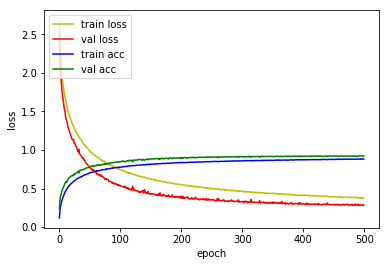

4815/4815 [==============================] - 1s 302us/sample - loss: 0.3259 - acc: 0.9088
Loss: 0.3258861377479379 Accuracy: 0.9088266

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6473 - acc: 0.1283
Epoch 00001: val_loss improved from inf to 2.40547, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/001-2.4055.hdf5
36805/36805 [==============================] - 20s 556us/sample - loss: 2.6472 - acc: 0.1284 - val_loss: 2.4055 - val_acc: 0.2530
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2535 - acc: 0.2633
Epoch 00002: val_loss improved from 2.40547 to 1.95135, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/002-1.9514.hdf5
36805/36805 [==============================] - 18s 479us/sample - loss: 2.2535 - acc: 0.2633 - val_loss: 1.9514 - val_acc: 0.4044
Epoch 3/500
36800/36805 [==========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8845 - acc: 0.7353
Epoch 00022: val_loss improved from 0.68724 to 0.64878, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/022-0.6488.hdf5
36805/36805 [==============================] - 17s 474us/sample - loss: 0.8845 - acc: 0.7353 - val_loss: 0.6488 - val_acc: 0.8230
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8683 - acc: 0.7408
Epoch 00023: val_loss improved from 0.64878 to 0.63675, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/023-0.6367.hdf5
36805/36805 [==============================] - 17s 468us/sample - loss: 0.8682 - acc: 0.7409 - val_loss: 0.6367 - val_acc: 0.8220
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8448 - acc: 0.7476
Epoch 00024: val_loss improved from 0.63675 to 0.61744, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_ch

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5843 - acc: 0.8270
Epoch 00045: val_loss improved from 0.40280 to 0.38673, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/045-0.3867.hdf5
36805/36805 [==============================] - 17s 470us/sample - loss: 0.5842 - acc: 0.8270 - val_loss: 0.3867 - val_acc: 0.8980
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5724 - acc: 0.8290
Epoch 00046: val_loss improved from 0.38673 to 0.37633, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/046-0.3763.hdf5
36805/36805 [==============================] - 17s 472us/sample - loss: 0.5723 - acc: 0.8290 - val_loss: 0.3763 - val_acc: 0.8989
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5716 - acc: 0.8317
Epoch 00047: val_loss did not improve from 0.37633
36805/36805 [==============================] - 17s 466us/sample - loss: 0.5716 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.4582 - acc: 0.8626
Epoch 00069: val_loss did not improve from 0.29626
36805/36805 [==============================] - 17s 468us/sample - loss: 0.4581 - acc: 0.8626 - val_loss: 0.3034 - val_acc: 0.9143
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4566 - acc: 0.8644
Epoch 00070: val_loss improved from 0.29626 to 0.29264, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/070-0.2926.hdf5
36805/36805 [==============================] - 17s 470us/sample - loss: 0.4566 - acc: 0.8644 - val_loss: 0.2926 - val_acc: 0.9206
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4519 - acc: 0.8655
Epoch 00071: val_loss did not improve from 0.29264
36805/36805 [==============================] - 17s 468us/sample - loss: 0.4518 - acc: 0.8655 - val_loss: 0.2982 - val_acc: 0.9192
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3883 - acc: 0.8814
Epoch 00096: val_loss did not improve from 0.25426
36805/36805 [==============================] - 17s 465us/sample - loss: 0.3883 - acc: 0.8814 - val_loss: 0.2570 - val_acc: 0.9327
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8833
Epoch 00097: val_loss improved from 0.25426 to 0.25258, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/097-0.2526.hdf5
36805/36805 [==============================] - 17s 470us/sample - loss: 0.3890 - acc: 0.8833 - val_loss: 0.2526 - val_acc: 0.9331
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3828 - acc: 0.8856
Epoch 00098: val_loss improved from 0.25258 to 0.24990, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/098-0.2499.hdf5
36805/36805 [==============================] - 17s 467us/sample - loss: 0.3828 - a

Epoch 122/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3452 - acc: 0.8974
Epoch 00122: val_loss did not improve from 0.22206
36805/36805 [==============================] - 17s 467us/sample - loss: 0.3452 - acc: 0.8974 - val_loss: 0.2330 - val_acc: 0.9385
Epoch 123/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3374 - acc: 0.8974
Epoch 00123: val_loss did not improve from 0.22206
36805/36805 [==============================] - 17s 467us/sample - loss: 0.3374 - acc: 0.8974 - val_loss: 0.2383 - val_acc: 0.9380
Epoch 124/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3378 - acc: 0.8990
Epoch 00124: val_loss did not improve from 0.22206
36805/36805 [==============================] - 17s 469us/sample - loss: 0.3377 - acc: 0.8991 - val_loss: 0.2277 - val_acc: 0.9394
Epoch 125/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3335 - acc: 0.8985
Epoch 00125: val_loss did not improve from 0.22206
36805/36805 [=

Epoch 150/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3093 - acc: 0.9068
Epoch 00150: val_loss did not improve from 0.21007
36805/36805 [==============================] - 17s 470us/sample - loss: 0.3093 - acc: 0.9068 - val_loss: 0.2155 - val_acc: 0.9429
Epoch 151/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3031 - acc: 0.9078
Epoch 00151: val_loss did not improve from 0.21007
36805/36805 [==============================] - 17s 466us/sample - loss: 0.3031 - acc: 0.9078 - val_loss: 0.2126 - val_acc: 0.9432
Epoch 152/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3072 - acc: 0.9068
Epoch 00152: val_loss improved from 0.21007 to 0.20911, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv_checkpoint/152-0.2091.hdf5
36805/36805 [==============================] - 17s 468us/sample - loss: 0.3072 - acc: 0.9068 - val_loss: 0.2091 - val_acc: 0.9418
Epoch 153/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.2810 - acc: 0.9146
Epoch 00177: val_loss did not improve from 0.19535
36805/36805 [==============================] - 17s 468us/sample - loss: 0.2810 - acc: 0.9146 - val_loss: 0.2019 - val_acc: 0.9446
Epoch 178/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2811 - acc: 0.9148
Epoch 00178: val_loss did not improve from 0.19535
36805/36805 [==============================] - 17s 467us/sample - loss: 0.2811 - acc: 0.9148 - val_loss: 0.2128 - val_acc: 0.9422
Epoch 179/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2786 - acc: 0.9141
Epoch 00179: val_loss did not improve from 0.19535
36805/36805 [==============================] - 17s 466us/sample - loss: 0.2787 - acc: 0.9141 - val_loss: 0.2154 - val_acc: 0.9422
Epoch 180/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2737 - acc: 0.9155
Epoch 00180: val_loss did not improve from 0.19535
36805/36805 [===============

Epoch 206/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2581 - acc: 0.9211
Epoch 00206: val_loss did not improve from 0.18846
36805/36805 [==============================] - 17s 466us/sample - loss: 0.2580 - acc: 0.9211 - val_loss: 0.1942 - val_acc: 0.9497
Epoch 207/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2620 - acc: 0.9195
Epoch 00207: val_loss did not improve from 0.18846
36805/36805 [==============================] - 17s 464us/sample - loss: 0.2622 - acc: 0.9195 - val_loss: 0.1967 - val_acc: 0.9490
Epoch 208/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2546 - acc: 0.9216
Epoch 00208: val_loss did not improve from 0.18846
36805/36805 [==============================] - 17s 467us/sample - loss: 0.2546 - acc: 0.9216 - val_loss: 0.1904 - val_acc: 0.9502
Epoch 209/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2569 - acc: 0.9203
Epoch 00209: val_loss improved from 0.18846 to 0.18809, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 0.2357 - acc: 0.9258
Epoch 00234: val_loss did not improve from 0.18602
36805/36805 [==============================] - 17s 469us/sample - loss: 0.2359 - acc: 0.9258 - val_loss: 0.1925 - val_acc: 0.9509
Epoch 235/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2412 - acc: 0.9234
Epoch 00235: val_loss did not improve from 0.18602
36805/36805 [==============================] - 17s 466us/sample - loss: 0.2413 - acc: 0.9234 - val_loss: 0.1966 - val_acc: 0.9506
Epoch 236/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2383 - acc: 0.9259
Epoch 00236: val_loss did not improve from 0.18602
36805/36805 [==============================] - 17s 467us/sample - loss: 0.2382 - acc: 0.9259 - val_loss: 0.1931 - val_acc: 0.9506
Epoch 237/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2357 - acc: 0.9252
Epoch 00237: val_loss did not improve from 0.18602
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9274
Epoch 00263: val_loss did not improve from 0.18162
36805/36805 [==============================] - 17s 463us/sample - loss: 0.2264 - acc: 0.9274 - val_loss: 0.2059 - val_acc: 0.9481
Epoch 264/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2266 - acc: 0.9289
Epoch 00264: val_loss did not improve from 0.18162
36805/36805 [==============================] - 17s 464us/sample - loss: 0.2266 - acc: 0.9289 - val_loss: 0.1924 - val_acc: 0.9520
Epoch 265/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2241 - acc: 0.9293
Epoch 00265: val_loss did not improve from 0.18162
36805/36805 [==============================] - 17s 466us/sample - loss: 0.2241 - acc: 0.9293 - val_loss: 0.1961 - val_acc: 0.9490
Epoch 266/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2260 - acc: 0.9287
Epoch 00266: val_loss did not improve from 0.18162
36805/36805 [===============


1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv Model


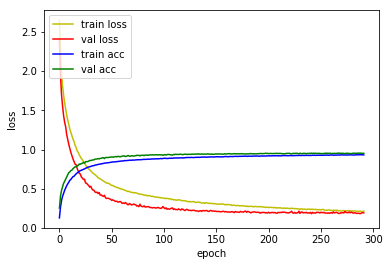

4815/4815 [==============================] - 1s 284us/sample - loss: 0.2175 - acc: 0.9369
Loss: 0.21751798870407532 Accuracy: 0.93686396

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5828 - acc: 0.1527
Epoch 00001: val_loss improved from inf to 2.11480, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_7_conv_checkpoint/001-2.1148.hdf5
36805/36805 [==============================] - 21s 567us/sample - loss: 2.5827 - acc: 0.1527 - val_loss: 2.1148 - val_acc: 0.3704
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9921 - acc: 0.3523
Epoch 00002: val_loss improved from 2.11480 to 1.53910, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_7_conv_checkpoint/002-1.5391.hdf5
36805/36805 [==============================] - 18s 481us/sample - loss: 1.9920 - acc: 0.3523 - val_loss: 1.5391 - val_acc: 0.5260
Epoch 3/500
36800/36805 [========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6010 - acc: 0.8139
Epoch 00022: val_loss improved from 0.40554 to 0.40348, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_7_conv_checkpoint/022-0.4035.hdf5
36805/36805 [==============================] - 18s 477us/sample - loss: 0.6010 - acc: 0.8139 - val_loss: 0.4035 - val_acc: 0.8812
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5788 - acc: 0.8232
Epoch 00023: val_loss improved from 0.40348 to 0.40000, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_7_conv_checkpoint/023-0.4000.hdf5
36805/36805 [==============================] - 18s 480us/sample - loss: 0.5788 - acc: 0.8232 - val_loss: 0.4000 - val_acc: 0.8789
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5592 - acc: 0.8277
Epoch 00024: val_loss improved from 0.40000 to 0.37534, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_7_conv_ch

36800/36805 [============================>.] - ETA: 0s - loss: 0.3664 - acc: 0.8853
Epoch 00044: val_loss improved from 0.23472 to 0.23106, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_7_conv_checkpoint/044-0.2311.hdf5
36805/36805 [==============================] - 17s 475us/sample - loss: 0.3664 - acc: 0.8853 - val_loss: 0.2311 - val_acc: 0.9341
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3686 - acc: 0.8867
Epoch 00045: val_loss improved from 0.23106 to 0.22688, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_7_conv_checkpoint/045-0.2269.hdf5
36805/36805 [==============================] - 18s 476us/sample - loss: 0.3686 - acc: 0.8867 - val_loss: 0.2269 - val_acc: 0.9338
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3625 - acc: 0.8888
Epoch 00046: val_loss did not improve from 0.22688
36805/36805 [==============================] - 17s 474us/sample - loss: 0.3625 - acc: 0.8888 - 

Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2707 - acc: 0.9161
Epoch 00069: val_loss improved from 0.18421 to 0.18258, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_7_conv_checkpoint/069-0.1826.hdf5
36805/36805 [==============================] - 18s 478us/sample - loss: 0.2707 - acc: 0.9161 - val_loss: 0.1826 - val_acc: 0.9474
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2672 - acc: 0.9177
Epoch 00070: val_loss did not improve from 0.18258
36805/36805 [==============================] - 17s 474us/sample - loss: 0.2672 - acc: 0.9177 - val_loss: 0.1831 - val_acc: 0.9474
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2715 - acc: 0.9154
Epoch 00071: val_loss did not improve from 0.18258
36805/36805 [==============================] - 17s 475us/sample - loss: 0.2715 - acc: 0.9154 - val_loss: 0.1853 - val_acc: 0.9474
Epoch 72/500
36800/36805 [============================>.] -

Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2199 - acc: 0.9298
Epoch 00095: val_loss did not improve from 0.15384
36805/36805 [==============================] - 18s 476us/sample - loss: 0.2200 - acc: 0.9298 - val_loss: 0.1706 - val_acc: 0.9509
Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2161 - acc: 0.9305
Epoch 00096: val_loss did not improve from 0.15384
36805/36805 [==============================] - 17s 473us/sample - loss: 0.2161 - acc: 0.9305 - val_loss: 0.1603 - val_acc: 0.9527
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2141 - acc: 0.9323
Epoch 00097: val_loss did not improve from 0.15384
36805/36805 [==============================] - 17s 474us/sample - loss: 0.2140 - acc: 0.9323 - val_loss: 0.1606 - val_acc: 0.9520
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2127 - acc: 0.9322
Epoch 00098: val_loss did not improve from 0.15384
36805/36805 [=====

Epoch 123/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1801 - acc: 0.9421
Epoch 00123: val_loss did not improve from 0.14671
36805/36805 [==============================] - 18s 476us/sample - loss: 0.1801 - acc: 0.9421 - val_loss: 0.1483 - val_acc: 0.9571
Epoch 124/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1766 - acc: 0.9427
Epoch 00124: val_loss did not improve from 0.14671
36805/36805 [==============================] - 18s 477us/sample - loss: 0.1766 - acc: 0.9428 - val_loss: 0.1498 - val_acc: 0.9574
Epoch 125/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1797 - acc: 0.9417
Epoch 00125: val_loss did not improve from 0.14671
36805/36805 [==============================] - 18s 476us/sample - loss: 0.1796 - acc: 0.9417 - val_loss: 0.1500 - val_acc: 0.9576
Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1747 - acc: 0.9433
Epoch 00126: val_loss did not improve from 0.14671
36805/36805 [=

Epoch 151/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1540 - acc: 0.9489
Epoch 00151: val_loss did not improve from 0.13993
36805/36805 [==============================] - 18s 476us/sample - loss: 0.1540 - acc: 0.9489 - val_loss: 0.1451 - val_acc: 0.9578
Epoch 152/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1511 - acc: 0.9508
Epoch 00152: val_loss did not improve from 0.13993
36805/36805 [==============================] - 17s 475us/sample - loss: 0.1511 - acc: 0.9508 - val_loss: 0.1428 - val_acc: 0.9595
Epoch 153/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1466 - acc: 0.9522
Epoch 00153: val_loss did not improve from 0.13993
36805/36805 [==============================] - 18s 476us/sample - loss: 0.1466 - acc: 0.9522 - val_loss: 0.1498 - val_acc: 0.9588
Epoch 154/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1512 - acc: 0.9505
Epoch 00154: val_loss did not improve from 0.13993
36805/36805 [=

Epoch 180/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9565
Epoch 00180: val_loss did not improve from 0.13814
36805/36805 [==============================] - 18s 476us/sample - loss: 0.1299 - acc: 0.9565 - val_loss: 0.1484 - val_acc: 0.9578
Epoch 181/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1302 - acc: 0.9574
Epoch 00181: val_loss did not improve from 0.13814
36805/36805 [==============================] - 17s 474us/sample - loss: 0.1302 - acc: 0.9574 - val_loss: 0.1561 - val_acc: 0.9583
Epoch 182/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1313 - acc: 0.9552
Epoch 00182: val_loss did not improve from 0.13814
36805/36805 [==============================] - 18s 480us/sample - loss: 0.1313 - acc: 0.9552 - val_loss: 0.1508 - val_acc: 0.9597
Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1277 - acc: 0.9564
Epoch 00183: val_loss did not improve from 0.13814
36805/36805 [=

Epoch 210/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1172 - acc: 0.9603
Epoch 00210: val_loss did not improve from 0.13814
36805/36805 [==============================] - 18s 476us/sample - loss: 0.1172 - acc: 0.9603 - val_loss: 0.1505 - val_acc: 0.9609
Epoch 211/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1138 - acc: 0.9605
Epoch 00211: val_loss did not improve from 0.13814
36805/36805 [==============================] - 18s 478us/sample - loss: 0.1138 - acc: 0.9605 - val_loss: 0.1506 - val_acc: 0.9620
Epoch 212/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1184 - acc: 0.9603
Epoch 00212: val_loss did not improve from 0.13814
36805/36805 [==============================] - 18s 478us/sample - loss: 0.1184 - acc: 0.9603 - val_loss: 0.1507 - val_acc: 0.9611
Epoch 213/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1176 - acc: 0.9599
Epoch 00213: val_loss did not improve from 0.13814
36805/36805 [=

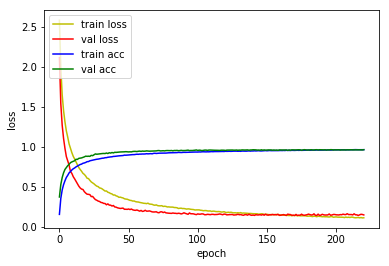

4815/4815 [==============================] - 1s 282us/sample - loss: 0.2004 - acc: 0.9418
Loss: 0.20042766913199103 Accuracy: 0.9418484

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3746 - acc: 0.2193
Epoch 00001: val_loss improved from inf to 1.68085, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_8_conv_checkpoint/001-1.6809.hdf5
36805/36805 [==============================] - 23s 621us/sample - loss: 2.3745 - acc: 0.2193 - val_loss: 1.6809 - val_acc: 0.5269
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6483 - acc: 0.4703
Epoch 00002: val_loss improved from 1.68085 to 1.20398, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_8_conv_checkpoint/002-1.2040.hdf5
36805/36805 [==============================] - 18s 492us/sample - loss: 1.6483 - acc: 0.4703 - val_loss: 1.2040 - val_acc: 0.6632
Epoch 3/500
36800/36805 [=========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.4071 - acc: 0.8733
Epoch 00022: val_loss improved from 0.27482 to 0.26897, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_8_conv_checkpoint/022-0.2690.hdf5
36805/36805 [==============================] - 18s 493us/sample - loss: 0.4071 - acc: 0.8734 - val_loss: 0.2690 - val_acc: 0.9178
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3957 - acc: 0.8767
Epoch 00023: val_loss improved from 0.26897 to 0.26567, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_8_conv_checkpoint/023-0.2657.hdf5
36805/36805 [==============================] - 18s 493us/sample - loss: 0.3956 - acc: 0.8768 - val_loss: 0.2657 - val_acc: 0.9157
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3824 - acc: 0.8785
Epoch 00024: val_loss improved from 0.26567 to 0.24753, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_8_conv_checkpoint/024-

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2372 - acc: 0.9249
Epoch 00047: val_loss did not improve from 0.17242
36805/36805 [==============================] - 18s 490us/sample - loss: 0.2371 - acc: 0.9250 - val_loss: 0.1768 - val_acc: 0.9448
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2326 - acc: 0.9258
Epoch 00048: val_loss improved from 0.17242 to 0.17144, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_8_conv_checkpoint/048-0.1714.hdf5
36805/36805 [==============================] - 18s 497us/sample - loss: 0.2326 - acc: 0.9258 - val_loss: 0.1714 - val_acc: 0.9467
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2282 - acc: 0.9265
Epoch 00049: val_loss improved from 0.17144 to 0.16431, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_8_conv_checkpoint/049-0.1643.hdf5
36805/36805 [==============================] - 18s 491us/sample - loss: 0.2282 - a

Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1635 - acc: 0.9467
Epoch 00074: val_loss did not improve from 0.14286
36805/36805 [==============================] - 18s 492us/sample - loss: 0.1635 - acc: 0.9467 - val_loss: 0.1481 - val_acc: 0.9539
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1581 - acc: 0.9486
Epoch 00075: val_loss did not improve from 0.14286
36805/36805 [==============================] - 18s 496us/sample - loss: 0.1582 - acc: 0.9486 - val_loss: 0.1485 - val_acc: 0.9522
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9488
Epoch 00076: val_loss did not improve from 0.14286
36805/36805 [==============================] - 18s 493us/sample - loss: 0.1569 - acc: 0.9487 - val_loss: 0.1463 - val_acc: 0.9550
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1568 - acc: 0.9483
Epoch 00077: val_loss did not improve from 0.14286
36805/36805 [=====

Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1219 - acc: 0.9593
Epoch 00103: val_loss did not improve from 0.13870
36805/36805 [==============================] - 18s 494us/sample - loss: 0.1219 - acc: 0.9593 - val_loss: 0.1488 - val_acc: 0.9574
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1142 - acc: 0.9618
Epoch 00104: val_loss did not improve from 0.13870
36805/36805 [==============================] - 18s 500us/sample - loss: 0.1142 - acc: 0.9618 - val_loss: 0.1425 - val_acc: 0.9557
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1103 - acc: 0.9624
Epoch 00105: val_loss did not improve from 0.13870
36805/36805 [==============================] - 18s 497us/sample - loss: 0.1103 - acc: 0.9624 - val_loss: 0.1407 - val_acc: 0.9553
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1116 - acc: 0.9620
Epoch 00106: val_loss did not improve from 0.13870
36805/36805 [=

Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9692
Epoch 00133: val_loss did not improve from 0.13870
36805/36805 [==============================] - 18s 488us/sample - loss: 0.0892 - acc: 0.9692 - val_loss: 0.1572 - val_acc: 0.9583
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0863 - acc: 0.9706
Epoch 00134: val_loss did not improve from 0.13870
36805/36805 [==============================] - 18s 485us/sample - loss: 0.0863 - acc: 0.9706 - val_loss: 0.1606 - val_acc: 0.9576
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0862 - acc: 0.9707
Epoch 00135: val_loss did not improve from 0.13870
36805/36805 [==============================] - 18s 498us/sample - loss: 0.0862 - acc: 0.9707 - val_loss: 0.1574 - val_acc: 0.9560
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0861 - acc: 0.9703
Epoch 00136: val_loss did not improve from 0.13870
36805/36805 [=

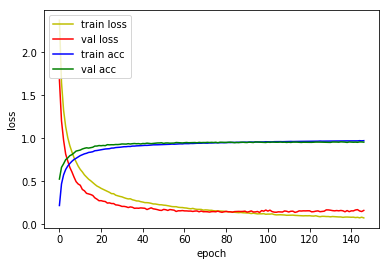

4815/4815 [==============================] - 2s 324us/sample - loss: 0.2176 - acc: 0.9396
Loss: 0.2175688793199951 Accuracy: 0.9395639



In [10]:
base = '1D_CNN_custom_multi_2_GAP_ch_32_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GAP_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
____________________________________________________________

4815/4815 [==============================] - 1s 306us/sample - loss: 0.3259 - acc: 0.9088
Loss: 0.3258861377479379 Accuracy: 0.9088266

1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 32)    192         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 32)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPoo

4815/4815 [==============================] - 2s 317us/sample - loss: 0.2004 - acc: 0.9418
Loss: 0.20042766913199103 Accuracy: 0.9418484

1D_CNN_custom_multi_2_GAP_ch_32_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 32)    192         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 32)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPo

In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GAP_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
____________________________________________________________

4815/4815 [==============================] - 2s 345us/sample - loss: 0.3212 - acc: 0.9078
Loss: 0.321175901689262 Accuracy: 0.90778816

1D_CNN_custom_multi_2_GAP_ch_32_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 32)    192         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 32)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPoo

4815/4815 [==============================] - 2s 354us/sample - loss: 0.2095 - acc: 0.9448
Loss: 0.20951838995390965 Accuracy: 0.944756

1D_CNN_custom_multi_2_GAP_ch_32_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 32)    192         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 32)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPoo